# Denoising Diffusion Probabilistic Models with miniai

Now that we written our own barebones training library, let's make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We'll start with building and training the model described in the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). For more context, while diffusion models were technically invented [back in 2015](https://arxiv.org/abs/1503.03585), diffusion models flew under the radar until this 2020 paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Let's get started and train our own DDPM!

## Imports

We'll start with some imports.

In [3]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11
!pip install tokenizers
!pip install torchdata==0.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.7.26
    Uninstalling fastcore-1.7.26:
      Successfully uninstalled fastcore-1.7.26
  Attempting uninstall: torch
    Found exis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2 --cache-dir /content/drive/MyDrive/pip_cache

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the dataset

We will load the dataset from HuggingFace Hub:

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:

In [6]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of **unconditional** image generation.

In [7]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)#转换数据集格式
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb

(torch.Size([128, 1, 32, 32]),
 tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1, 2, 3, 2, 3, 3, 7, 9, 9, 3, 2, 4, 6, 3, 5,
         5, 3, 2, 0, 0, 8, 4, 2, 8, 5, 9, 2, 4, 9, 4, 4, 3, 4, 9, 7, 2, 0, 4, 5,
         4, 8, 2, 6, 7, 0, 2, 0, 6, 3, 3, 5, 6, 0, 0, 8, 7, 5, 1, 3, 5, 1, 0, 8,
         6, 6, 6, 7, 5, 3, 2, 1, 8, 1, 6, 3, 4, 3, 6, 3, 4, 6, 9, 9, 1, 2, 2, 0,
         3, 8, 7, 9, 4, 5, 6, 7, 8, 7, 6, 6, 9, 3, 9, 8, 9, 2, 4, 7, 5, 3, 2, 0,
         2, 4, 6, 9, 9, 1, 5, 9]))

## Create model

We will create a U-net. A U-net looks something like this:

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="700">

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from the diffusers library:

In [8]:
from diffusers import UNet2DModel

0it [00:00, ?it/s]

In [9]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image


We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [10]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):#加噪
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)#随机初始噪声
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [11]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

Now let's run the fit function:

loss,epoch,train
0.055,0,train
0.027,0,eval
0.022,1,train
0.020,1,eval
0.019,2,train
0.017,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.015,4,eval


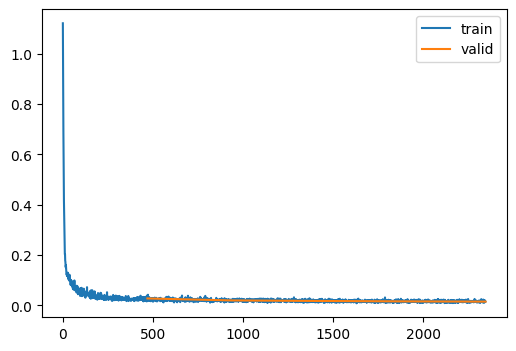

In [12]:
learn.fit(epochs)

In [13]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [14]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [15]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## Inference

Now that we've trained our model, let's generate some images with our model:

In [16]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

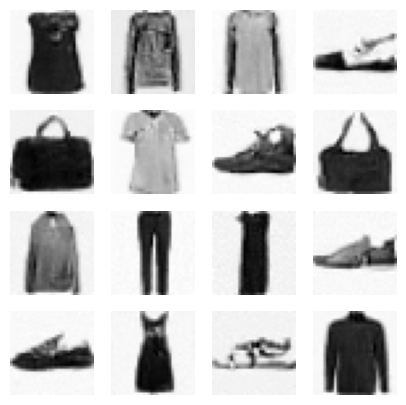

In [17]:
show_images(-samples[-1], figsize=(5,5))

Let's visualize the sampling process:

In [18]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object at 0x7fafbeb03a80>


Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of the noise schedule used for small images, and papers like [Improved DDPM](https://arxiv.org/abs/2102.09672) suggest other noise schedules for this purpose! (Some potential homework: try out the noise schedule from Improved DDPM and see if it helps.)